In [ ]:
# Importação das bibliotecas
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
import time
from tensorflow.keras import layers
from IPython import display

# Alterar o tipo de execução para GPU no
# menu RAM/Disco para acelerar o processo

In [ ]:
# Importação do dataset do vestuário (apenas os dados de treino serão usados)
(X_treino, d_treino), (_, _) = tf.keras.datasets.fashion_mnist.load_data()
X_treino.shape

4422102/4422102 [==============================] - 0s 0us/step


(60000, 28, 28)

In [ ]:
novos_exemplos_gerados = 25
novas_sementes = tf.random.normal([novos_exemplos_gerados, dimens_semente])
novas_imagens = generator(novas_sementes, training=False)
fig = plt.figure(figsize=(5, 5))

for i in range(novas_imagens.shape[0]):
    plt.subplot(5, 5, i+1)
    plt.imshow(novas_imagens[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')

plt.show()

In [ ]:
# Indicação das camadas das imagens para convolução e normalização entre -1 e +1
X_treino = X_treino.reshape(X_treino.shape[0], 28, 28, 1).astype('float32')
X_treino = (X_treino - 127.5) / 127.5

In [ ]:
# Ordenação aleatória do dataset e divisão em lotes
batch_lote = 256
total_imagens_reais = len(X_treino)
dataset_treino = tf.data.Dataset.from_tensor_slices(X_treino).shuffle(total_imagens_reais).batch(batch_lote)

In [ ]:
def rede_geradora_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # "None" é o tamanho da Batch (lote)

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

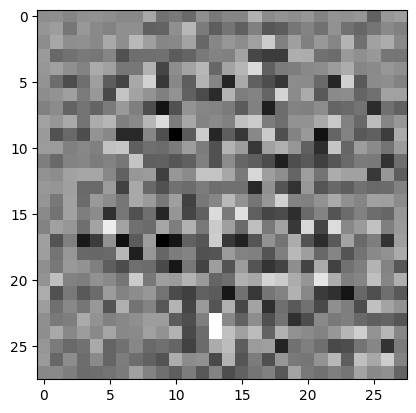

In [ ]:
generator = rede_geradora_model()

ruido = tf.random.normal([1, 100])
imagem_gerada = generator(ruido)

plt.imshow(imagem_gerada[0, :, :, 0], cmap='gray')

In [ ]:
def rede_classificacao_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [ ]:
discriminator = rede_classificacao_model()
decision = discriminator(imagem_gerada)
print (decision)

tf.Tensor([[-0.00066304]], shape=(1, 1), dtype=float32)


In [ ]:
# Função auxiliar para cálculo do erro de treino por entropia cruzada (cross entropy)
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [ ]:
# Indicação da quantidade de épocas de treino, tamanho da semente de entrada
epocas = 150
dimens_semente = 100

# Geração de 16 sementes fixas para que se possa acompanhar visualmente a melhoria das imagens
num_exemplos_gerados = 16
seed = tf.random.normal([num_exemplos_gerados, dimens_semente])

In [ ]:
# O uso de `tf.function` permite que a função seja 'compilada' para que possa ser 'chamada'
@tf.function
def passo_de_treino(images):
    semente = tf.random.normal([batch_lote, dimens_semente])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(semente, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [ ]:
# Para que se possa acompanhar visualmente o treinamento, o processo é decomposto em:

def treino(dataset, epocas):
  for epoca in range(epocas):
    start = time.time()

    # 1. Um passo de treinamento com anotação do tempo de cada época
    for image_batch in dataset:
      passo_de_treino(image_batch)

    # 2. Produção das imagens para serem visualizadas durante a aprendizagem
    display.clear_output(wait=True)
    generate_and_save_images(generator, epoca + 1, seed)

    # 3. Checkpoint para salvar o treinamento a cada 15 épocas
    if (epoca + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoca {} is {} sec'.format(epoca + 1, time.time()-start))

  # Geração do último conjunto de imagens após a conclusão do treinamento
  display.clear_output(wait=True)
  generate_and_save_images(generator, epoca + 1, seed)

In [ ]:
# Na execução da rede deve ocorrer apenas o processo de inferência
# por isso o parâmetro: 'training=False'
def generate_and_save_images(model, epoca, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoca_{:04d}.png'.format(epoca))
  plt.show()

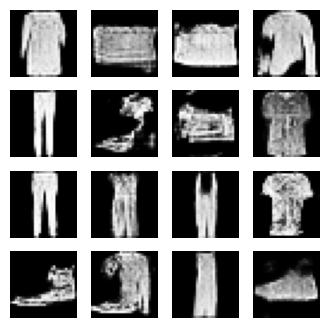

In [ ]:
treino(dataset_treino, epocas)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))